In [1]:
import numpy as np
import os
import pandas as pd
import glob
import h3

# Tasks:
1. Comapre the pixel level changes between images aggregated to hexagon level (focusing on increase)
2. Main changes to identify: building, greenery, sidewalk, all kinds of furniture
3. Aggregate the changes to h3 level 6, 9, 12 and plot the variation in map

In [52]:
# sample one city to conduct the test
# cityabbr = "london"
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"

EXFOLDER = os.path.join(CURATED_FOLDER, "c_seg_crossectional")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
    
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal")
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)

# panoptic_df = get_result(cityabbr,CURATED_FOLDER, f_suffixes = "*panoptic.csv")
# seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
# meta_df = pd.read_csv(META_PATH.format(
#     ROOTFOLDER = ROOTFOLDER,
#     cityabbr = cityabbr
# ))
# pano_df = pd.read_csv(PANO_PATH.format(
#     ROOTFOLDER = ROOTFOLDER,
#     cityabbr = cityabbr
# ))[['panoid', 'lat', 'lon', 'year', 'month']]

# for res in [6,9,12]:
#     pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)

In [53]:
# the id, labels ranges from 0 to 149
# path to data labels: _playground/OneFormer/oneformer/data/datasets/register_ade20k_instance.py
TOTAL_PX = 160000

building = [0, 1, 25, 48]
greenery = [4, 9, 17, 66, 72]
street_furniture = [19, 15, 31, 69, 82, 136, 138]
sidewalk = [11]
car = [20, 80, 83, 102]
person = [12]
bike = [127, 116]
sky = [2]
sel = building + greenery + street_furniture + sidewalk + car + person + bike +sky
other = [x for x in range(150) if not x in sel]

obj_dicts = {
    "building":building,
    "greenery":greenery,
    "street_furniture":street_furniture,
    "sidewalk": sidewalk,
    "car":car,
    "person":person,
    "bike":bike,
    "sky":sky,
    "other":other,
}
def get_cat(label):
    for obj, v in obj_dicts.items():
        if label in v:
            return obj
obj_dict_rev = {}
for x in range(150):
    obj_dict_rev[x] = get_cat(x)
ops = {}
for label in list(obj_dicts.keys())[:-1]:
    ops[label] = "mean"

In [72]:
def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

def clean_seg(seg_df, ring):
    seg_df['cat'] = seg_df['labels'].apply(lambda x: obj_dict_rev[x])
    seg_df_summary = seg_df.groupby(["img", "cat"]).agg({'areas':'sum'}).reset_index()
    seg_df_summary = seg_df_summary[seg_df_summary["cat"]!="other"].reset_index(drop = True)
    seg_df_summary['panoid'] = seg_df_summary['img'].apply(lambda x: x[:22])
    seg_df_summary_pano = seg_df_summary.merge(ring, on = ['panoid'])
    if seg_df_summary_pano.shape[0]<seg_df_summary.shape[0]:
        print("data missing after data join.")
    else:
        print("data consistent")
    col_cols = ["cat"]
    index_cols = ["img", "year", "h3_6", "h3_9", "h3_12", "ring"]
    seg_df_summary_pano = seg_df_summary_pano.drop_duplicates(index_cols+col_cols)
    print("Segmentation shape: ", seg_df_summary_pano.shape[0])
    seg_df_pivot = seg_df_summary_pano.pivot(
        columns = ["cat"],
        index = ["img", "year", "h3_6", "h3_9", "h3_12", "ring"],
        values = "areas"
    ).reset_index().fillna(0)
    return seg_df_pivot

def get_crossectional(seg_df_pivot):
    h3_summary_no_year = []
    for res in [6, 9, 12]:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = seg_df_pivot.groupby([f'h3_{res}', 'ring']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id"})
        df_h3_summary["res"] = res
        h3_summary_no_year.append(df_h3_summary)
        print("resolution: ", res)
    h3_summary_no_year = pd.concat(h3_summary_no_year).reset_index(drop = True)
    return h3_summary_no_year

# assume the data can be understand every year
def get_longitudinal(seg_df_pivot):
    year_group1 = [2015,2016,2017,2018]
    year_group2 = [2020, 2021, 2022, 2023]
    null_group = [2019] # do not use this for now
    seg_df_summary_pano = seg_df_pivot[~seg_df_pivot["year"].isin(null_group)].reset_index(drop = True)
    seg_df_summary_pano['year_group'] = np.where(seg_df_summary_pano["year"]<=2018, '2015-2018', '2020-2023')
    h3_summary = []
    for res in [6, 9, 12]:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = seg_df_summary_pano.groupby([f'h3_{res}','ring','year_group']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id"})
        df_h3_summary["res"] = res
        h3_summary.append(df_h3_summary)
    h3_summary = pd.concat(h3_summary).reset_index(drop = True)
    return h3_summary


def load_data(city):
    cityabbr = city.lower().replace(" ", "")
    seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
    pano_df = pd.read_csv(PANO_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
    ))[['panoid', 'lat', 'lon', 'year', 'month']]

    for res in [6,9,12]:
        pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
        
    meta_df = pd.read_csv(META_PATH.format(
        ROOTFOLDER = ROOTFOLDER,
        cityabbr = cityabbr
    ))

    ring = meta_df[['panoid', 'ring']].drop_duplicates().dropna().merge(pano_df, on = "panoid", how = "right")
    ring["ring"] = ring["ring"].fillna(-1)
    # here make sure 
    
    seg_df_pivot = clean_seg(seg_df, ring)
    seg_crossectional = get_crossectional(seg_df_pivot)
    seg_longitudinal = get_longitudinal(seg_df_pivot)

    seg_crossectional.to_parquet(os.path.join(EXFOLDER, cityabbr+".parquet"), index = False)
    seg_longitudinal.to_parquet(os.path.join(EXFOLDER_LONG, cityabbr+".parquet"), index = False)
    print(f"city {cityabbr} saved")
    print("*"*50)


In [63]:

serviceaccount = "../../google_drive_personal.json"
import gspread

# from oauth2client.service_account import ServiceAccountCredentials
gc = gspread.service_account(filename=serviceaccount)


def read_url(url, SHEET_NAME):
    SHEET_ID = url.split("/")[5]
    spreadsheet = gc.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet


url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
city_meta, other_worksheet = read_url(url, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)

In [74]:
for city in city_meta["City"].values[1:]:

    load_data(city)


data consistent
Segmentation shape:  35270
resolution:  6
resolution:  9
resolution:  12
city hindupur saved
**************************************************


In [ ]:
# seg_df['total_pixel'] = seg_df.groupby('img')['areas'].transform(sum)
# print(seg_df['total_pixel'].describe())
# seg_df.drop('total_pixel', axis = 1, inplace = True)


In [14]:
# load the original dictionary and summary data by selected SVF
seg_df['cat'] = seg_df['labels'].apply(lambda x: obj_dict_rev[x])
seg_df_summary = seg_df.groupby(["img", "cat"]).agg({'areas':'sum'}).reset_index()
seg_df_summary = seg_df_summary[seg_df_summary["cat"]!="other"].reset_index(drop = True)
seg_df_summary['panoid'] = seg_df_summary['img'].apply(lambda x: x[:22])
seg_df_summary_pano = seg_df_summary.merge(pano_df, on = ['panoid'])

seg_df_summary_pano = seg_df_summary.merge(ring, on = ['panoid'])
if seg_df_summary_pano.shape[0]<seg_df_summary.shape[0]:
    print("data missing after data join.")
else:
    print("data consistent")

In [33]:
seg_df_pivot = seg_df_summary_pano.pivot(
    columns = ["cat"],
    index = ["img", "year", "h3_6", "h3_9", "h3_12", "ring"],
    values = "areas"
).reset_index().fillna(0)

# summary all crossectional
h3_summary_no_year = []
for res in [6, 9, 12]:
    # for each resolution of h3 id we get a average pixel of one category
    df_h3_summary = seg_df_pivot.groupby([f'h3_{res}', 'ring']).agg(ops).reset_index()\
    .rename(columns = {f'h3_{res}':"hex_id"})
    df_h3_summary["res"] = res
    h3_summary_no_year.append(df_h3_summary)
h3_summary_no_year = pd.concat(h3_summary_no_year).reset_index(drop = True)
h3_summary_no_year

<Axes: xlabel='ring', ylabel='sidewalk'>

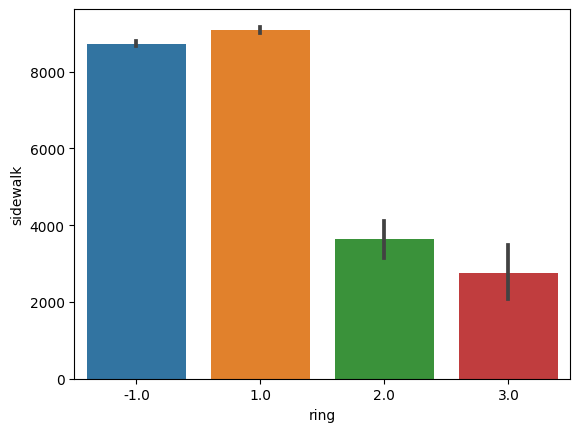

In [45]:
import seaborn as sns
sns.barplot(
    data = h3_summary_no_year[h3_summary_no_year["res"]==9],
    x = "ring",
    y = "sidewalk"
)

In [9]:
# assume the data can be understand every year
def get_longitudinal(seg_df_summary_pano):
    year_group1 = [2015,2016,2017,2018]
    year_group2 = [2020, 2021, 2022, 2023]
    null_group = [2019] # do not use this for now
    seg_df_summary_pano = seg_df_summary_pano[~seg_df_summary_pano["year"].isin(null_group)].reset_index(drop = True)
    seg_df_summary_pano['year_group'] = np.where(seg_df_summary_pano["year"]<=2018, '2015-2018', '2020-2023')
    h3_summary = []
    for res in [6, 9, 12]:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = seg_df_summary_pano.groupby([f'h3_{res}','year_group']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id"})
        df_h3_summary["res"] = res
        h3_summary.append(df_h3_summary)
    h3_summary = pd.concat(h3_summary).reset_index(drop = True)
    return h3_summary


,hex_id,year_group,cat,areas,res
0,86194ac07ffffff,2015-2018,bike,100852,6
1,86194ac07ffffff,2015-2018,building,164702672,6
2,86194ac07ffffff,2015-2018,car,61198737,6
3,86194ac07ffffff,2015-2018,greenery,535945632,6
4,86194ac07ffffff,2015-2018,person,414276,6
...,...,...,...,...,...
1497586,8c195db6bbacbff,2020-2023,sidewalk,4803,12
1497587,8c195db6bbb33ff,2015-2018,building,40069,12
1497588,8c195db6bbb33ff,2015-2018,car,3828,12
1497589,8c195db6bbb33ff,2015-2018,greenery,36641,12


In [11]:
seg_df_summary_pano.head()

,img,cat,areas,panoid,lat,lon,year,month,h3_6,h3_9,h3_12
0,---dBf3I-RAe01Gw6EmRdw_0,building,53449,---dBf3I-RAe01Gw6EmRdw,51.65006,-0.175045,2015.0,9.0,86195db5fffffff,89195db5b23ffff,8c195db5b234bff
1,---dBf3I-RAe01Gw6EmRdw_0,car,15063,---dBf3I-RAe01Gw6EmRdw,51.65006,-0.175045,2015.0,9.0,86195db5fffffff,89195db5b23ffff,8c195db5b234bff
2,---dBf3I-RAe01Gw6EmRdw_0,greenery,3441,---dBf3I-RAe01Gw6EmRdw,51.65006,-0.175045,2015.0,9.0,86195db5fffffff,89195db5b23ffff,8c195db5b234bff
3,---dBf3I-RAe01Gw6EmRdw_0,sidewalk,6035,---dBf3I-RAe01Gw6EmRdw,51.65006,-0.175045,2015.0,9.0,86195db5fffffff,89195db5b23ffff,8c195db5b234bff
4,---dBf3I-RAe01Gw6EmRdw_180,building,30125,---dBf3I-RAe01Gw6EmRdw,51.65006,-0.175045,2015.0,9.0,86195db5fffffff,89195db5b23ffff,8c195db5b234bff


In [12]:
seg_df_summary_pano['year'].unique()

array([2015., 2016., 2020., 2019., 2017., 2018., 2022., 2021., 2023.])

In [13]:
seg_df_summary_pano.groupby('year')['panoid'].nunique()

year
2015.0    50814
2016.0    34836
2017.0    40139
2018.0    75280
2019.0    48698
2020.0    37877
2021.0    38611
2022.0    46318
2023.0     8542
Name: panoid, dtype: int64

In [47]:
#############################################################
# process object counting later
panoptic_df["cat"] = panoptic_df["category_id"].apply(lambda x: obj_dict_rev[x])
panoptic_df = panoptic_df[~panoptic_df['cat'].isin(['other', 'greenery'])].reset_index(drop = True)
p_summary = panoptic_df[panoptic_df['isthing']==True].groupby(["img","cat"])['id'].nunique().reset_index()
p_summary.head()

,img,cat,id
0,---dBf3I-RAe01Gw6EmRdw_0,car,1
1,---dBf3I-RAe01Gw6EmRdw_180,car,1
2,---dBf3I-RAe01Gw6EmRdw_180,person,1
3,---dBf3I-RAe01Gw6EmRdw_180,street_furniture,2
4,---dBf3I-RAe01Gw6EmRdw_270,car,1


In [48]:
p_summary.groupby(['cat'])['id'].sum()

cat
bike                  35387
car                 1482455
person               201622
street_furniture     206277
Name: id, dtype: int64